In [ ]:
import numpy as np
import pandas as pd
import string

# Use conda to install graphviz and python-graphviz
import graphviz

import dask.array
import dask.dataframe
from dask.dot import dot_graph

In [22]:
# Use pip to install memory_profiler 
# !pip install -U memory_profiler
# You can load it to work as a magic command through %%memit
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


## graphviz

Package for representing graphs. A graph is a collection of dots called nodes and lines called edges. The nodes are the entries of the graph and the lines are the relationships between entries. 

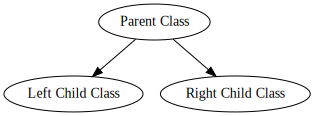

In [9]:
dot = graphviz.Digraph(comment='UML Diagram')

dot.node('A', 'Parent Class')
dot.node('L', 'Left Child Class')
dot.node('R', 'Right Child Class')

dot.edges(['AL', 'AR'])

dot

Remember that UML diagrams depict the relationship between classes. Each node is a class. Each edge indicates inheritance or composition.

## Dask Arrays

Computation

 - Provides operations on NumPy array and Pandas DataFrame objects 
 - Records the steps for calculations into dependent tasks
   * Lazy Evaluation: Values are not computed until needed for calculations. Unchanged values do not cause recalculation
   * Parallel Tasks: If tasks are not dependent, then they can run at the same time. This allows multiple computing resources
   
Storage   
 - If dataset does not fit into memory, then split into chunks for storage. 
    * Calculations for dataset mapped to calculations for chunks
    * Numbers for chunks reduced to numbers for the dataset

In [86]:
size_array = 10000000
number_partitions = 5

Operations in numpy

In [54]:
# create an array of normally-distributed random numbers
a = np.random.randn(size_array)

# multiply this array by a factor
b = a * 4

# find the minimum value
b_min = b.min()

# print minimum value
print(b_min)

-19.01070642936112


Operations in Dask

In [55]:
# create dask array broken into chunks of size 200
a2 = dask.array.from_array(a, chunks=size_array // number_partitions)

# multiply this array by a factor
b2 = a2 * 4

# find the minimum value
b2_min = b2.min()

# print minimum
print(b2_min)

dask.array<amin-aggregate, shape=(), dtype=float64, chunksize=()>


Operations in Dask are **lazy** meaning that the package computes necessary numbers but leaves out unnecessary. Still, the package stores the steps needed to compute the unnecessary numbers. 

In [56]:
b2_min.compute()

-19.01070642936112

The package stores the computation as a graph. The graph depicts each task as a node along with the dependencies of the tasks through edges. 

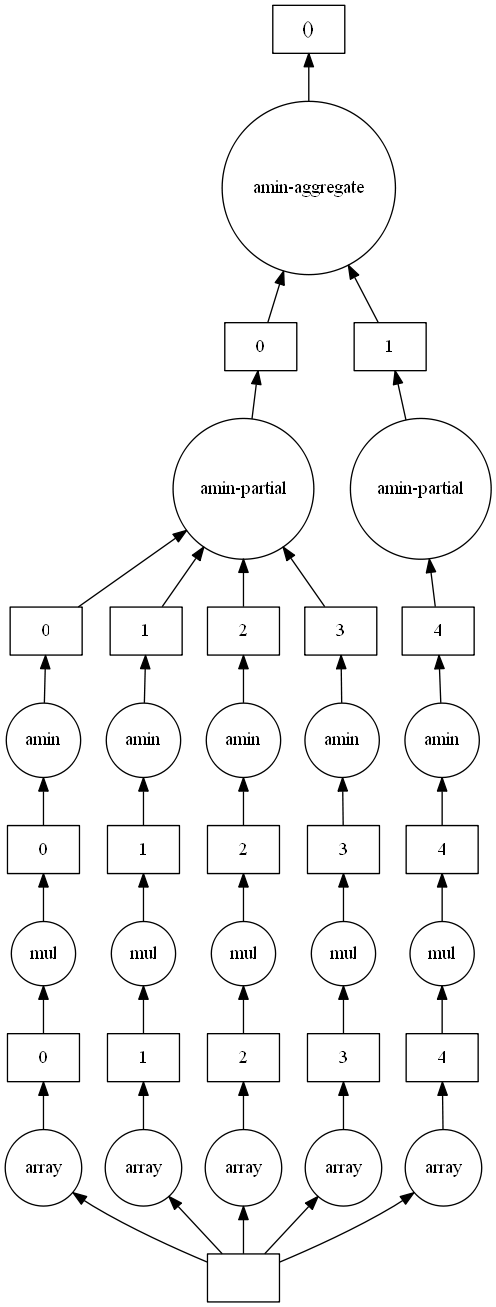

In [48]:
dot_graph(b2_min.dask)

We can track the usage of CPU and memory in Python using %%timeit and %%memit. For numpy

In [57]:
%%memit 

# create an array of normally-distributed random numbers
a = np.random.randn(size_array)

# multiply this array by a factor
b = a * 4

# find the minimum value
b_min = b.min()

# print minimum value
# print(b_min)

peak memory: 157.28 MiB, increment: 14.27 MiB


In [58]:
%%timeit

# create an array of normally-distributed random numbers
a = np.random.randn(size_array)

# multiply this array by a factor
b = a * 4

# find the minimum value
b_min = b.min()

# print minimum value
# print(b_min)

23.7 ms ± 388 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


For Dask

In [59]:
%%memit

# create dask array broken into chunks of size 200
a2 = dask.array.from_array(a, chunks=size_array // number_partitions)

# multiply this array by a factor
b2 = a2 * 4

# find the minimum value
b2_min = b2.min()

# print minimum
# print(b2_min)

b2_min.compute()

peak memory: 149.59 MiB, increment: -1.07 MiB


In [60]:
%%timeit

# create dask array broken into chunks of size 200
a2 = dask.array.from_array(a, chunks=size_array // number_partitions)

# multiply this array by a factor
b2 = a2 * 4

# find the minimum value
b2_min = b2.min()

# print minimum
# print(b2_min)

b2_min.compute()

17.5 ms ± 562 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Dask DataFrames

In [87]:
df = pd.DataFrame({"value": np.random.randn(size_array), 
                   "category": np.random.choice(list(string.ascii_uppercase),size=size_array)})
df.head()

,value,category
0,-2.542589,B
1,-0.031724,C
2,-0.506904,V
3,-0.988665,U
4,1.410857,E


Grouping Operation in pandas

In [95]:
%%memit

df.groupby(df['category'])['value'].max()

peak memory: 908.96 MiB, increment: 136.38 MiB


In [96]:
%%timeit

df.groupby(df['category'])['value'].max()

315 ms ± 3.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Grouping Operation in Dask

In [92]:
df2 = dask.dataframe.from_pandas(df,chunksize= size_array // number_partitions)

In [93]:
%%memit

df2.groupby(df['category'])['value'].max()

peak memory: 1202.37 MiB, increment: 429.78 MiB


In [94]:
%%timeit

df2.groupby(df['category'])['value'].max()

1.69 s ± 29.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
